In [3]:
import os
import ast
import sys
import json
import time
import yaml
from tqdm import trange

from pymongo import MongoClient
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
import matplotlib.pyplot as plt
import seaborn as sns


import pandas as pd
import numpy as np
from dotenv import load_dotenv
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
# Import libraries for working with language models and Google Gemini
from langchain_core.prompts import PromptTemplate
import google.generativeai as genai
from google.generativeai.types import HarmCategory, HarmBlockThreshold
from langchain_core.output_parsers import JsonOutputParser
from langchain_core.pydantic_v1 import BaseModel, Field
from langchain_groq import ChatGroq
from langchain_core.prompts import PromptTemplate

chat_model = "llama3-8b-8192"
load_dotenv()
groq_api_key = os.getenv('GROQ_API_KEY')
GEMINI_KEY = os.environ.get('GEMINI_KEY')
genai.configure(api_key=GEMINI_KEY)


# Normally where to do this? (in which function?)
with open("../config.yaml", "r") as config_file:
    config = yaml.safe_load(config_file)

# Initialise mongo client.
mongo_client = MongoClient(config["database"]["uri"])

- Extract the linkage first
- Find max and min distance, then go through clustering in intervals of 0.1 or smt. 
- 

In [21]:
def load_mongodb():
    # Connect to the MongoDB client
    try:
        db = mongo_client[config["database"]["name"]]
        train_documents = db[config["database"]["train_collection"]].find()
        print("Train data successfully fetched from MongoDB\n")
    except Exception as error: 
        print(f"Unable to fetch train data from MongoDB. Check your connection the database...\nERROR: {error}\n")
        sys.exit()   
    try:
        test_docs = db[config["database"]["test_collection"]].find()
        print("Test data successfully fetched from MongoDB\n")
    except:
        print(f"Unable to fetch test data from MongoDB. Check your connection the database...\nERROR: {error}\n")
        sys.exit()
    df_train = pd.DataFrame.from_dict(list(train_documents))
    df_test = pd.DataFrame.from_dict(list(test_docs))
    df = pd.concat([df_train, df_test], axis=0)
    return df

df= load_mongodb()
df.drop(['_id', "Text", "combined", "tags", "tags_embeddings", "Title_embeddings", "article_url", "phrase_Bert_tags_embeddings"], axis=1, inplace=True)


Train data successfully fetched from MongoDB

Test data successfully fetched from MongoDB



In [5]:
def scale_body_embeddings(df):
    print("Processing embedding data and scaling data...\n")
    #Deserializing the embeddings
    body_embeddings = np.array(df['embeddings'].apply(ast.literal_eval).tolist())
    
    # Standardize embeddings
    scaler = StandardScaler()
    embeddings = scaler.fit_transform(body_embeddings)
    return embeddings

def groq_header(s):
    # Define your desired data structure.
    class summarized_event(BaseModel):
        Title: str = Field(description="Common theme of article titles")
    
    parser = JsonOutputParser(pydantic_object=summarized_event)

    chat = ChatGroq(temperature=0, model_name=chat_model)
    
    template = '''
You are a news article editor. Given a list of article titles, you are to form a common theme for them in one sentence. 
I do not require an explanation, just the title that you deem well represents the common theme.

Series of article titles:
{text}

Answer format example:
{{"Title": "Israel-Hamas Conflict and Gaza Crisis"}}
{{"Title": "Tennis players throw rackets"}}

Before you return the answer, ensure and double check that you have adhered the answer format instructions strictly.
'''
    prompt = PromptTemplate(
        template=template,
        input_variables=["text"],
    )
    
    chain = prompt | chat 
    
    result = chain.invoke({"text": s}).content
    result = json.loads(result)
    return result['Title']

# Change type of embeddings accordingly
train_embeddings = scale_body_embeddings(df)

# Pre computed hierarchical clustering
Z = linkage(train_embeddings, method='average', metric='cosine')

Processing embedding data and scaling data...



In [6]:
# Extract the distances from the linkage matrix
distances = Z[:, 2]

# Calculate min_d and max_d
min_d = np.min(distances[np.nonzero(distances)])
max_d = np.max(distances)

print(f"Minimum distance (min_d): {min_d}")
print(f"Maximum distance (max_d): {max_d}")


Minimum distance (min_d): 0.010190938052364262
Maximum distance (max_d): 1.049064017073765


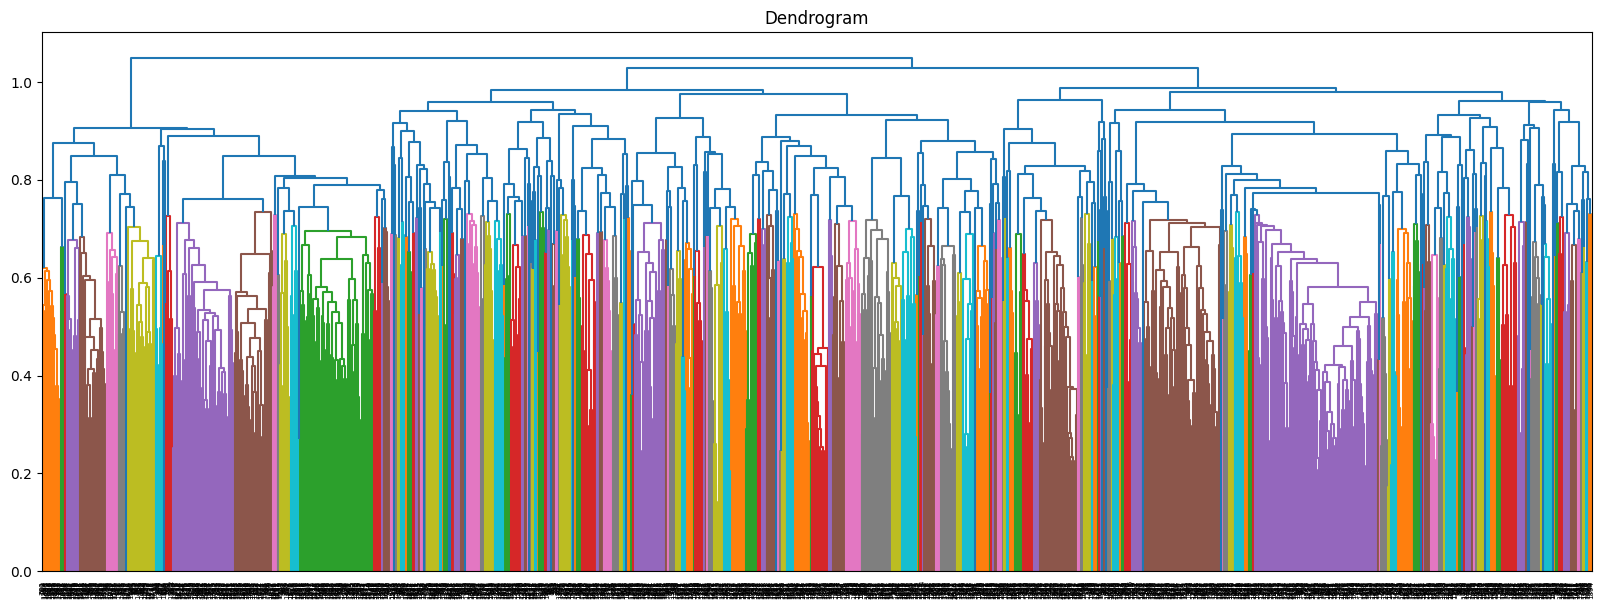

In [7]:
# Plot the dendrogram for the sub-cluster
plt.figure(figsize=(20, 7))
plt.title(f"Dendrogram")
dendrogram(Z)
plt.show()

In [79]:
d_ranges = np.arange(max_d,min_d,-0.01)
yes_break = False
dic = {}

for i in range(len(d_ranges)):
    yes_break = False
    clusters_train = fcluster(Z, d_ranges[i], criterion='distance')
    
    # Get unique elements and their counts
    unique_elements, counts = np.unique(clusters_train, return_counts=True)

    # Combine unique elements and counts into a dictionary for better readability
    cluster_counts = dict(zip(unique_elements, counts))  

    # Extract the counts (number of articles in each cluster)
    article_counts = np.array(list(cluster_counts.values()))
    num_clusters = len(article_counts)
    print(f"Level {i+1}")
    print("num clusters " + str(num_clusters))
    print("num of articles: " + f"{list(cluster_counts.values())}")

    cluster_to_label = []

    count = cluster_counts.values()
    for num in count:
        if num >30:
            yes_break = True
    
    if not yes_break:
        break
    else:
        dic[i] = {}
        dic[i]['max_d'] = d_ranges[i]
        dic[i]['num_clusters'] = num_clusters
        dic[i]['cluster_counts'] = cluster_counts
        

# Code above to extract the clusters that have at least one cluster with min 30 in their count. So this is the base bottom level

Level 1
num clusters 1
num of articles: [2007]
Level 2
num clusters 2
num of articles: [452, 1555]
Level 3
num clusters 2
num of articles: [452, 1555]
Level 4
num clusters 3
num of articles: [452, 792, 763]
Level 5
num clusters 3
num of articles: [452, 792, 763]
Level 6
num clusters 3
num of articles: [452, 792, 763]
Level 7
num clusters 3
num of articles: [452, 792, 763]
Level 8
num clusters 6
num of articles: [452, 311, 481, 136, 409, 218]
Level 9
num clusters 7
num of articles: [452, 311, 149, 332, 136, 409, 218]
Level 10
num clusters 10
num of articles: [452, 146, 165, 149, 332, 123, 13, 409, 122, 96]
Level 11
num clusters 11
num of articles: [452, 146, 165, 149, 332, 123, 13, 409, 122, 46, 50]
Level 12
num clusters 15
num of articles: [452, 65, 81, 68, 97, 149, 332, 123, 13, 22, 387, 122, 46, 3, 47]
Level 13
num clusters 18
num of articles: [452, 65, 81, 68, 20, 77, 149, 149, 183, 123, 13, 22, 387, 51, 71, 46, 3, 47]
Level 14
num clusters 22
num of articles: [452, 65, 12, 69, 68, 

In [80]:
num_levels = max(dic.keys())

clusters_at_levels = {}

for i in range(num_levels, -1, -1):
    cluster_nums_above_30 = [cluster_num for cluster_num, count in dic[i]['cluster_counts'].items() if 30 < count]
    print(cluster_nums_above_30)
    clusters_train = fcluster(Z, dic[i]['max_d'], criterion='distance')

    # At the maximum max_d of dic[num_levels]['max_d'], in this case 62 levels
    # list(clusters_train).count(cluster_nums_above_30[0])
    clusters_at_levels[i] = {}
    df['labels'] = clusters_train
    level_df = df.sort_values('labels').reset_index(drop=True)
    
    # for c_num in cluster_nums_above_30:
    #     clusters_at_levels[i][c_num] = {}
    #     cluster_titles = list(level_df[level_df['labels'] == c_num].Title)
    #     clusters_at_levels[i][c_num]['cluster_header'] = groq_header(cluster_titles)
    #     clusters_at_levels[i][c_num]['cluster_ids'] = list(level_df[level_df['labels'] == c_num].st_id)
        
    if i <= 56:
        break
clusters_at_levels


[1023]
[989]
[953]
[921]
[885]
[850]
[812]


{62: {}, 61: {}, 60: {}, 59: {}, 58: {}, 57: {}, 56: {}}

In [81]:
for c_num in cluster_nums_above_30:
    clusters_at_levels[num_levels][c_num] = {}
    cluster_titles = list(level_df[level_df['labels'] == c_num].Title)
    clusters_at_levels[num_levels][c_num]['cluster_header'] = groq_header(cluster_titles)
    clusters_at_levels[num_levels][c_num]['cluster_ids'] = list(level_df[level_df['labels'] == c_num].st_id)
    
clusters_at_levels

{62: {812: {'cluster_header': 'Israel-Hamas Conflict and Gaza Crisis',
   'cluster_ids': ['st_1163000',
    'st_1158342',
    'st_1154457',
    'st_1160482',
    'st_1158752',
    'st_1160289',
    'st_1158878',
    'st_1159230',
    'st_1155620',
    'st_1159239',
    'st_1160659',
    'st_1163343',
    'st_1157341',
    'st_1158485',
    'st_1159525',
    'st_1158980',
    'st_1158147',
    'st_1161648',
    'st_1158779',
    'st_1154989',
    'st_1164969',
    'st_1158751',
    'st_1153484',
    'st_1155254',
    'st_1156961',
    'st_1159953',
    'st_1164990',
    'st_1158236',
    'st_1161386',
    'st_1162818',
    'st_1161726',
    'st_1155395',
    'st_1158945',
    'st_1162016',
    'st_1163559',
    'st_1160979',
    'st_1154856',
    'st_1157276',
    'st_1163482',
    'st_1153853',
    'st_1162923',
    'st_1159463',
    'st_1157199']}},
 61: {},
 60: {},
 59: {},
 58: {},
 57: {},
 56: {}}

In [88]:
df= load_mongodb()
df.drop(['_id', "Text", "combined", "tags", "tags_embeddings", "Title_embeddings", "article_url", "phrase_Bert_tags_embeddings"], axis=1, inplace=True)

for i in range(num_levels):
    clusters_train = fcluster(Z, d_ranges[i], criterion='distance')
    df[i+1] = clusters_train
levels_df = df.sort_values(num_levels).reset_index(drop=True)
levels_df = levels_df.T.drop_duplicates().T
levels_df

Train data successfully fetched from MongoDB

Test data successfully fetched from MongoDB



,Title,embeddings,Publication_date,st_id,1,2,4,8,9,10,...,53,54,55,56,57,58,59,60,61,62
0,Formula One’s Las Vegas race isn’t living up t...,"[-0.087318, 0.024784, -0.026537, 0.048244, -0....",2023-11-16,st_1162503,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
1,Lewis Hamilton defends F1 Las Vegas race after...,"[-0.051651, 0.038147, -0.027991, 0.042599, -0....",2023-11-17,st_1162871,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
2,GM plans F1 power unit supply to Andretti from...,"[-0.030203, 0.020637, -0.00491, 0.04463, 0.049...",2023-11-14,st_1162202,1,1,1,1,1,1,...,1,1,1,1,1,1,2,2,2,2
3,Aston Martin to enter Le Mans with Valkyrie fr...,"[-0.025536, -0.033738, 0.022647, 0.074484, 0.0...",2023-10-04,st_1152462,1,1,1,1,1,1,...,2,2,2,2,2,2,3,3,3,3
4,Netflix pairs PGA Tour stars with F1 drivers f...,"[-0.044927, 0.004274, -0.004709, 0.06028, -0.0...",2023-10-18,st_1155727,1,1,1,1,1,1,...,3,3,3,3,3,3,4,4,4,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2002,Rio gangsters torch at least 35 buses after Br...,"[-0.046311, 0.029154, 0.023046, 0.04252, 0.031...",2023-10-24,st_1157189,1,2,3,6,7,10,...,821,863,896,934,976,1019,1057,1098,1134,1173
2003,Brazil police launch fresh raids as part of Ja...,"[0.010534, 0.015149, -0.002725, 0.031807, -0.0...",2023-10-25,st_1157563,1,2,3,6,7,10,...,821,863,896,934,976,1019,1057,1098,1134,1173
2004,"Brazil school shooting kills girl, 17","[0.004118, 0.013227, 0.014178, 0.005982, 0.043...",2023-10-24,st_1157145,1,2,3,6,7,10,...,822,864,897,935,977,1020,1058,1099,1135,1174
2005,Colombian ex-soldier pleads guilty in plot to ...,"[0.022058, 0.118873, 0.034178, 0.038695, -0.01...",2023-09-08,st_1146034,1,2,3,6,7,10,...,823,865,898,936,978,1021,1059,1100,1136,1175


In [92]:
# For each level, which cluster has around the 30s range. or more than 30. 

# At level 62:
levels = list(np.arange(60,63))
level_count = {}

for level in levels:
    level_count[level] = {}
    # Get unique elements and their counts
    clusters_train = fcluster(Z, d_ranges[-1], criterion='distance')
    unique_elements, counts = np.unique(clusters_train, return_counts=True)

    # Combine unique elements and counts into a dictionary for better readability
    cluster_counts = dict(zip(unique_elements, counts))

    # Filter the numbers that appear more than 30 times
    above_30 = levels_df[level].value_counts()[levels_df[level].value_counts() > 30].index.tolist()
    within_30_40 = levels_df[level].value_counts()[(levels_df[level].value_counts() > 30) & (levels_df[level].value_counts() < 40)].index.tolist()

    level_count[level]['clusters_above_30'] = above_30
    level_count[level]['clusters_within_30_40'] = within_30_40

    for c_num in within_30_40:
        cluster_ids = list(levels_df[levels_df[level] == c_num].st_id)
        cluster_titles = list(levels_df[levels_df[level] == c_num].Title)
        cluster_header = groq_header(cluster_titles)
        level_count[level][cluster_header] = cluster_ids

level_count

{60: {'clusters_above_30': [921],
  'clusters_within_30_40': [921],
  'Israel-Hamas Conflict and Gaza Crisis': ['st_1158751',
   'st_1158980',
   'st_1161648',
   'st_1159230',
   'st_1160482',
   'st_1163000',
   'st_1160659',
   'st_1158147',
   'st_1158878',
   'st_1163343',
   'st_1159525',
   'st_1157341',
   'st_1159239',
   'st_1158342',
   'st_1154457',
   'st_1153484',
   'st_1163482',
   'st_1159953',
   'st_1161386',
   'st_1157199',
   'st_1158945',
   'st_1156961',
   'st_1162016',
   'st_1157276',
   'st_1162923',
   'st_1160979',
   'st_1164969',
   'st_1154856',
   'st_1158752',
   'st_1163559',
   'st_1164990',
   'st_1154989',
   'st_1155254',
   'st_1161726',
   'st_1155395',
   'st_1159463']},
 61: {'clusters_above_30': [953],
  'clusters_within_30_40': [953],
  'Israel-Hamas Conflict and Gaza Crisis': ['st_1158751',
   'st_1158980',
   'st_1161648',
   'st_1159230',
   'st_1160482',
   'st_1163000',
   'st_1160659',
   'st_1158147',
   'st_1158878',
   'st_1163343'

In [83]:
above_30 = levels_df[62].value_counts()[levels_df[62].value_counts() > 30].index.tolist()
above_30

[989]

In [ ]:
# At Level 55, there are 2 clusters with more than 30. 